In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import shapiro, ttest_ind
from scipy import stats
from matplotlib.gridspec import GridSpec
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statannotations.Annotator import Annotator
import statsmodels.api as sm
from statsmodels.formula.api import ols


Import and clean data

In [2]:
df = pd.read_csv('Data/Salinité + Nappe.csv')
#Date Type
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
#Convert into numeric 
cols = ['Profondeur de nappe (cm)','Salinité à -30cm piézo (g/L)', 'Salinité en surface piézo (g/L)', 'Salinité en surface dehors (g/L)', 'Salinité eau inter -30cm (g/L)']
df[cols] = df[cols].apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
#Separate study sites
df_babin = df[df['Localisation'] == 'Babin '].drop(columns=['Localisation'])
df_RS = df[df['Localisation'] == 'RS'].drop(columns=['Parcelle', 'Localisation'])


stations_babin = ["RB", "RH", "T", "A"]
stations_RS = ["B", "H", "F"]
dates_babin = sorted(df_babin["Date"].unique())
dates_RS = sorted(df_RS["Date"].unique())


$\textbf{SALINITY AT 30CM IN PIEZOMETER PLOTS}$

Salinity at 30 cm depth as a function of date, grouped by station at Babin

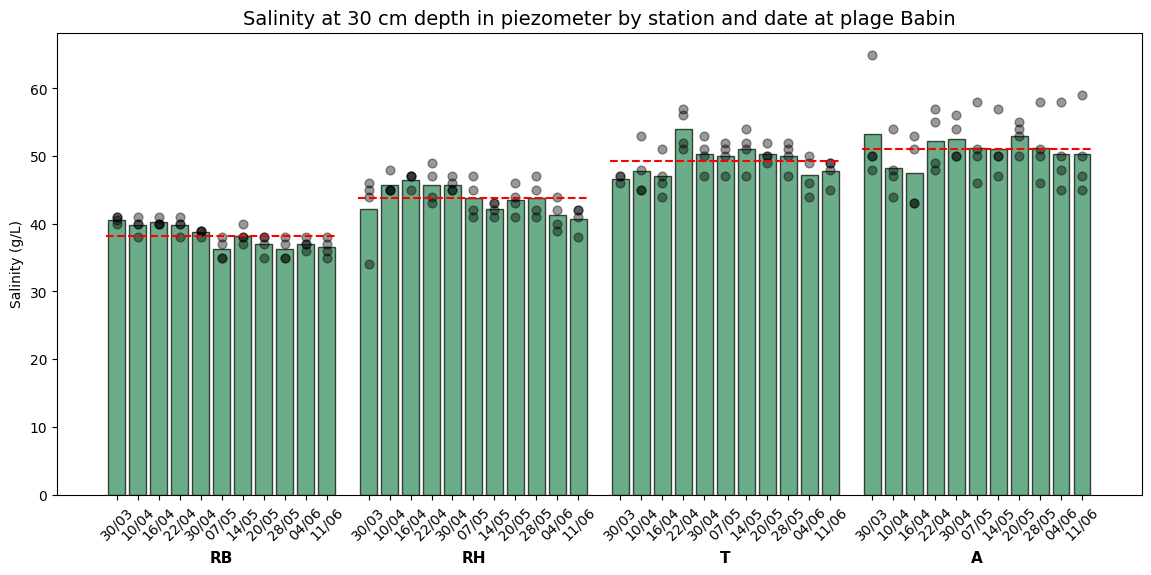

In [3]:
#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_babin[df_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data = station_df[station_df["Date"] == date]["Salinité à -30cm piézo (g/L)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    ax.hlines(
        y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("Salinity (g/L)")
ax.set_title("Salinity at 30 cm depth in piezometer by station and date at plage Babin", fontsize=14)

plt.savefig('Plot/Salinity_Babin.pdf', dpi=300, bbox_inches='tight')

ANOVA + Tukey for salinity
All data points from all plots and all measurement campaigns were grouped into 4 stations

38.21590909090909
43.75
49.325581395348834
50.97727272727273
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

RB vs. RH: Custom statistical test, P_val:0.000e+00
RH vs. T: Custom statistical test, P_val:0.000e+00
T vs. A: Custom statistical test, P_val:9.870e-02


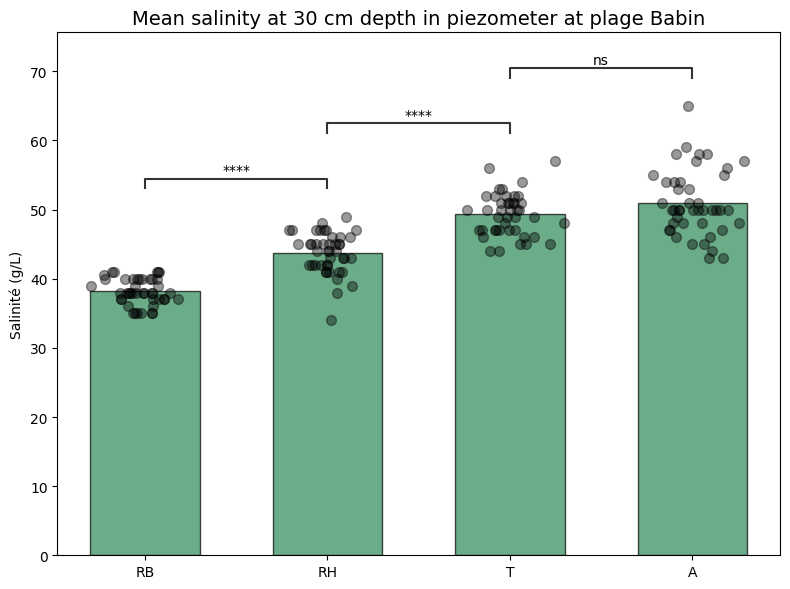

In [4]:

# Préparer data avec la bonne colonne Station
data = df_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_babin["Parcelle"].str.startswith(station)
    station_df = df_babin[station_mask]
    mean_depth = station_df["Salinité à -30cm piézo (g/L)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Salinité à -30cm piézo (g/L)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("Salinité (g/L)")
ax.set_title("Mean salinity at 30 cm depth in piezometer at plage Babin", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_Salinity_Babin.pdf', dpi=300, bbox_inches='tight')
plt.show()


Salinity at 30 cm depth as a function of date, grouped by station at RS

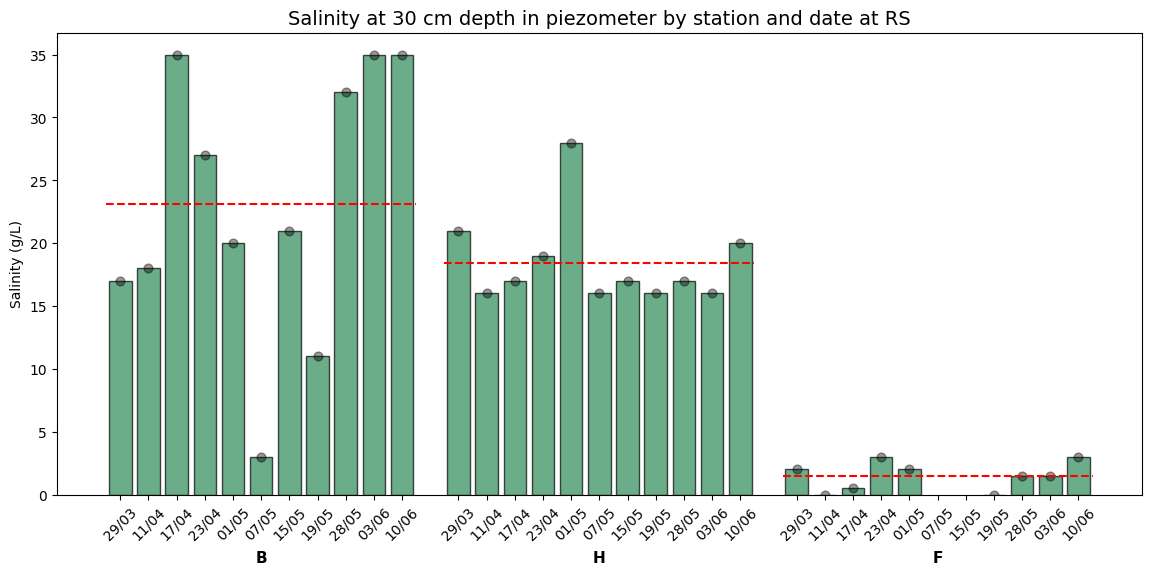

In [8]:
#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    group_center = i * (len(dates_RS) + spacing) + (len(dates_RS) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_RS):
        data = station_df[station_df["Date"] == date]["Salinité à -30cm piézo (g/L)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_RS) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_RS) + spacing) - 0.5
    end_x = start_x + len(dates_RS)

    ax.hlines(
        y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_RS] * len(stations_RS),  
    rotation=45,
    ha='center'
)


ax.set_ylabel("Salinity (g/L)")
ax.set_title("Salinity at 30 cm depth in piezometer by station and date at RS", fontsize=14)

plt.savefig('Plot/Salinity_RS.pdf', dpi=300, bbox_inches='tight')

ANOVA + Tukey for salinity
All data points from all plots and all measurement campaigns were grouped into 3 stations $\textbf{at RS}$

23.09090909090909
18.454545454545453
1.5
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. H: Custom statistical test, P_val:2.610e-01
H vs. F: Custom statistical test, P_val:0.000e+00
B vs. F: Custom statistical test, P_val:0.000e+00


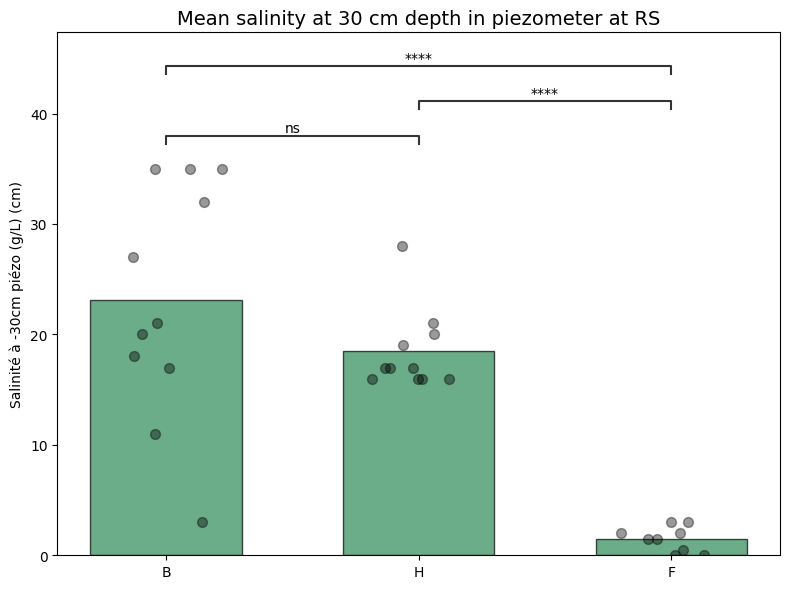

In [9]:

# Préparer data avec la bonne colonne Station
data = df_RS[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_RS))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    mean_depth = station_df["Salinité à -30cm piézo (g/L)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Salinité à -30cm piézo (g/L)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_RS)
ax.set_ylabel("Salinité à -30cm piézo (g/L) (cm)")
ax.set_title("Mean salinity at 30 cm depth in piezometer at RS", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("B", "H"), ("H", "F"), ("B", "F")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_Salinity_RS.pdf', dpi=300, bbox_inches='tight')
plt.show()


$\textbf{GROUNDWATER DEPTH IN PIEZOMETER PLOTS}$

Babin

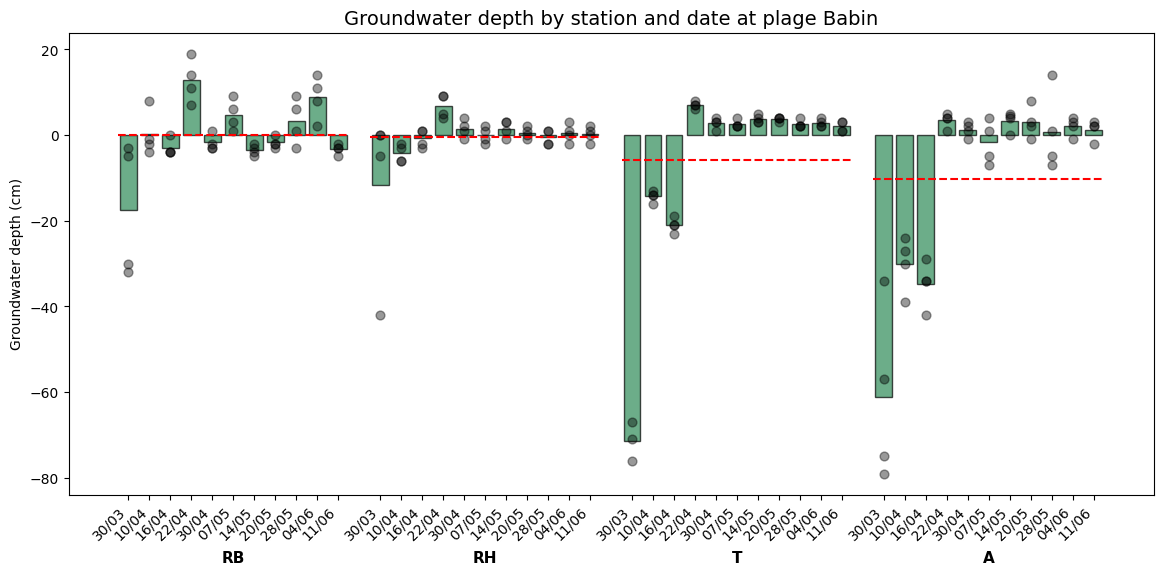

In [5]:

#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_babin[df_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data = station_df[station_df["Date"] == date]["Profondeur de nappe (cm)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    ax.hlines(
        y=station_df["Profondeur de nappe (cm)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Groundwater depth by station and date at plage Babin", fontsize=14)

plt.savefig('Plot/GroundWaterDepth_Babin.pdf', dpi=300, bbox_inches='tight')

RS

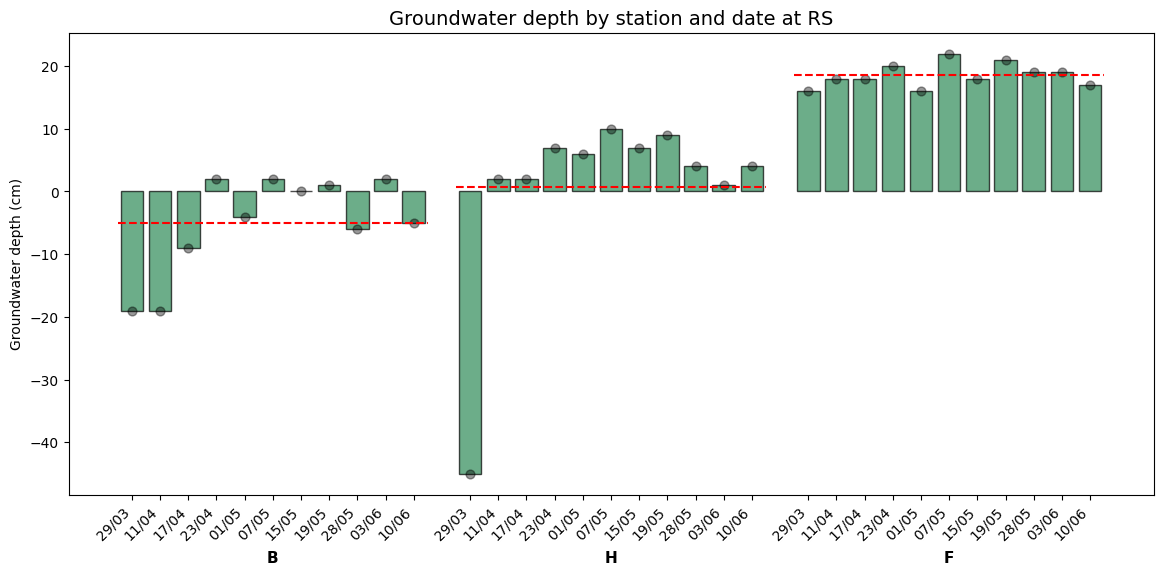

In [6]:

#Plot parameters
bar_width = 0.8
spacing = 1  

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    group_center = i * (len(dates_RS) + spacing) + (len(dates_RS) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_RS):
        data = station_df[station_df["Date"] == date]["Profondeur de nappe (cm)"]
        if len(data) == 0:
            continue
        x = i * (len(dates_RS) + spacing) + j  #bar position
        ax.bar(x, data.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
        ax.scatter([x]*len(data), data, color='black', alpha=0.4, s=40)
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)    

    # Mean line position
    start_x = i * (len(dates_RS) + spacing) - 0.5
    end_x = start_x + len(dates_RS)

    ax.hlines(
        y=station_df["Profondeur de nappe (cm)"].mean(),
        xmin=start_x,
        xmax=end_x ,  
        colors='red',
        linestyles='--',
        linewidth=1.5,
        label=f'Moyenne {station}' if i == 0 else ""
    )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_RS] * len(stations_RS),  
    rotation=45,
    ha='right'
)


ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Groundwater depth by station and date at RS", fontsize=14)

plt.savefig('Plot/GroundWaterDepth_RS.pdf', dpi=300, bbox_inches='tight')

-5.0
0.6363636363636364
18.545454545454547
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

B vs. H: Custom statistical test, P_val:3.981e-01
H vs. F: Custom statistical test, P_val:7.000e-04
B vs. F: Custom statistical test, P_val:0.000e+00


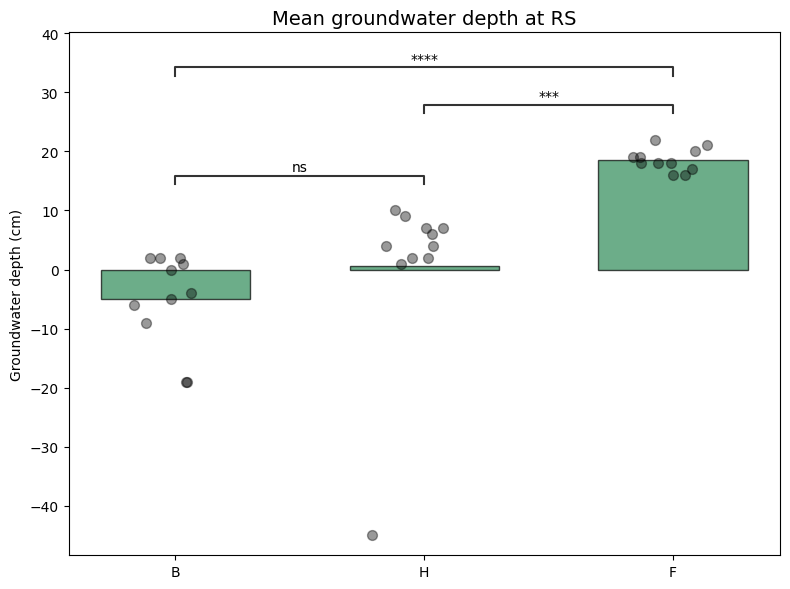

In [7]:

# Préparer data avec la bonne colonne Station
data = df_RS[["Profondeur de nappe (cm)", "Station"]].dropna()

# ANOVA + Tukey
model = ols('Q("Profondeur de nappe (cm)") ~ C(Station)', data=data).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
tukey = pairwise_tukeyhsd(endog=data["Profondeur de nappe (cm)"],
                          groups=data["Station"],
                          alpha=0.05)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 0.6
x_pos = range(len(stations_RS))

for i, station in enumerate(stations_RS):
    station_df = df_RS[df_RS["Station"]==station]
    mean_depth = station_df["Profondeur de nappe (cm)"].mean()
    ax.bar(x_pos[i], mean_depth, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.1, size=len(station_df))
    ax.scatter(x_pos[i] + jitter, station_df["Profondeur de nappe (cm)"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_RS)
ax.set_ylabel("Groundwater depth (cm)")
ax.set_title("Mean groundwater depth at RS", fontsize=14)

# --- Statannotations ---
# Comparaisons voulues
comparisons = [("B", "H"), ("H", "F"), ("B", "F")]

annotator = Annotator(ax, comparisons, data=data, x="Station", y="Profondeur de nappe (cm)")
annotator.configure(test=None, text_format='star')  # Pas de test automatique

# On injecte les p-values du test Tukey dans l'annotator
pvalues = []
for pair in comparisons:
    # Tukey retourne les p-values par paire dans tukey.summary()
    # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
    for row in tukey._results_table.data[1:]:
        if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
            pvalues.append(float(row[3]))
            break

annotator.set_pvalues(pvalues)
annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.savefig('Plot/Mean_GroundWaterDepth_RS.pdf', dpi=300, bbox_inches='tight')
plt.show()


$\textbf{MESURES MENSUELLES}$

Clean data

In [10]:
df_month = pd.read_csv('Data/Mesures Hebdo.csv')
#Date Type
df_month["Date"] = pd.to_datetime(df_month["Date"], dayfirst=True)
#Convert into numeric 
cols2 = ["pH piezo 30cm","DO piezo 30cm","redox piezo 30cm","pH eau de surface","DO eau de surface","redox eau de surface","pH eau inter","DO eau inter","redox eau inter"]
df_month[cols2] = df_month[cols2].apply(lambda col: pd.to_numeric(col.astype(str).str.replace(',', '.'), errors='coerce'))
#Separate study sites
df_month_babin = df_month[df_month['Localisation'] == 'Babin '].drop(columns=['Localisation'])
df_month_RS = df_month[df_month['Localisation'] == 'RS'].drop(columns=['Parcelle', 'Localisation'])


stations_babin = ["RB", "RH", "T", "A"]
stations_RS = ["B", "H", "F"]
dates_babin = sorted(df_month_babin["Date"].unique())
dates_RS = sorted(df_month_RS["Date"].unique())


pH Babin

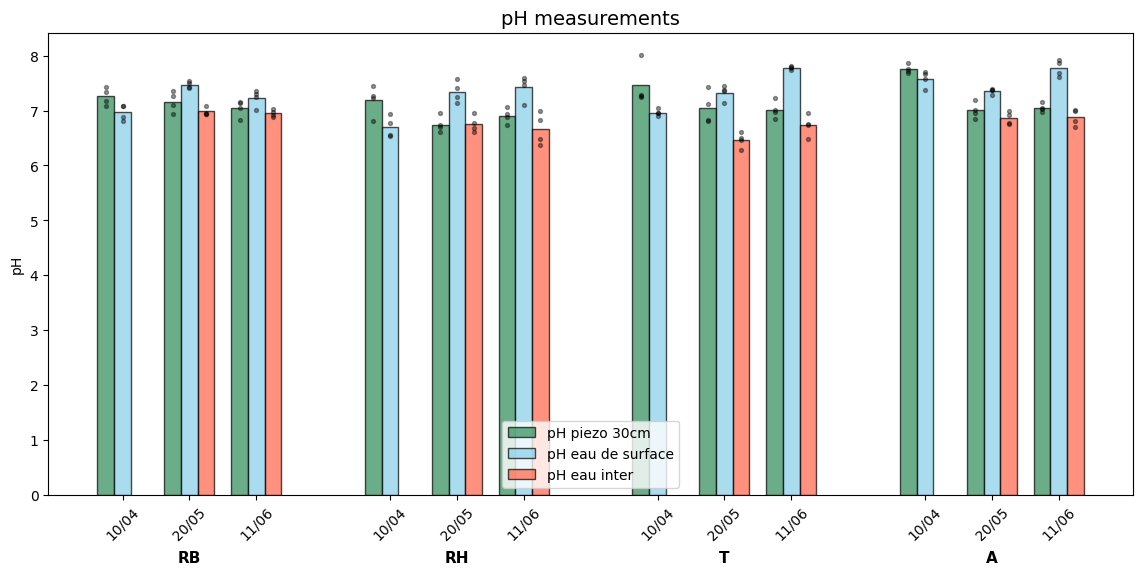

In [11]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["pH piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["pH eau de surface"]
        data3 = station_df[station_df["Date"] == date]["pH eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='pH piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='pH eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='pH eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("pH")
ax.set_title("pH measurements", fontsize=14)
ax.legend()
plt.savefig('Plot/pH_Babin.pdf', dpi=300, bbox_inches='tight')

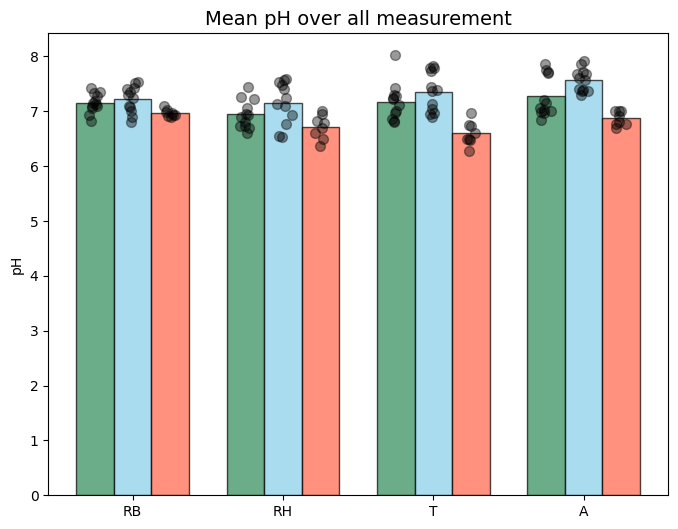

In [12]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_pH_piezo = station_df["pH piezo 30cm"].mean()
    mean_pH_surface = station_df["pH eau de surface"].mean()
    mean_pH_inter = station_df["pH eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_pH_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i], mean_pH_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i]+1/4, mean_pH_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black')
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["pH piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["pH eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["pH eau inter"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("pH")
ax.set_title("Mean pH over all measurement", fontsize=14)
ax.grid(False)
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_pH_Babin.pdf', dpi=300, bbox_inches='tight')

Dissolved Oxygen Babin

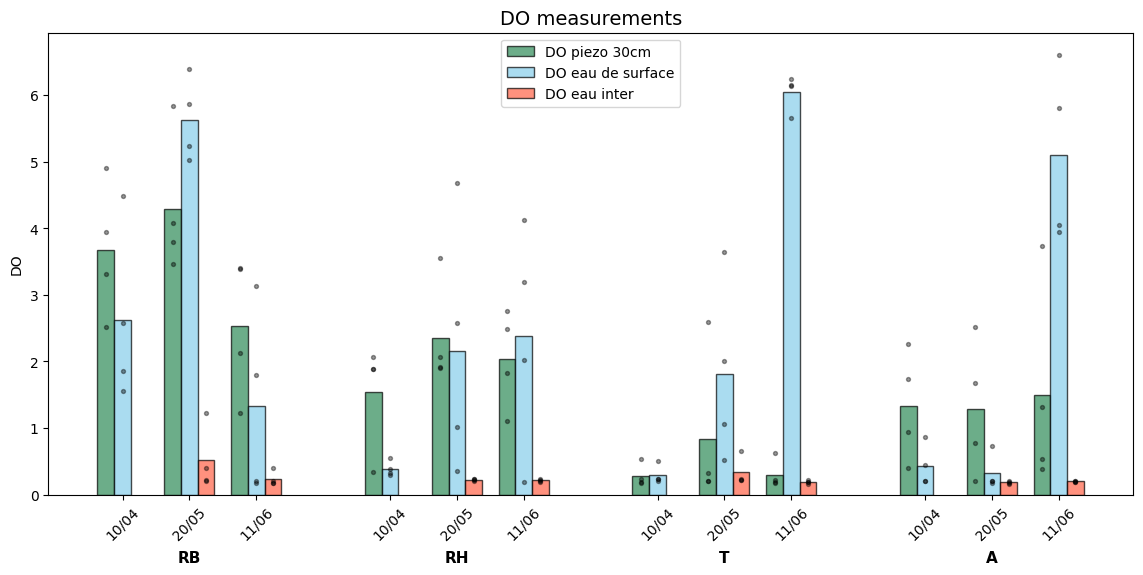

In [13]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["DO piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["DO eau de surface"]
        data3 = station_df[station_df["Date"] == date]["DO eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='DO piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='DO eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='DO eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

    
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)

ax.grid(False)
ax.set_ylabel("DO")
ax.set_title("DO measurements", fontsize=14)
ax.legend()
plt.savefig('Plot/DO_Babin.pdf', dpi=300, bbox_inches='tight')

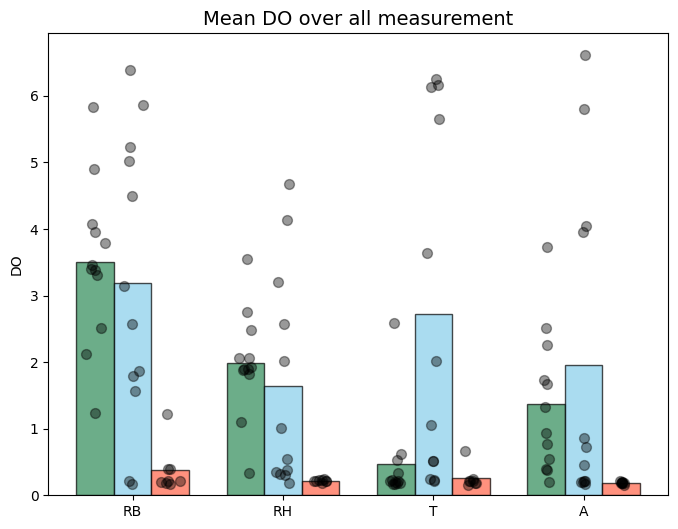

In [14]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(endog=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_DO_piezo = station_df["DO piezo 30cm"].mean()
    mean_DO_surface = station_df["DO eau de surface"].mean()
    mean_DO_inter = station_df["DO eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_DO_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i], mean_DO_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black')
    ax.bar(x_pos[i]+1/4, mean_DO_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black')
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["DO piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["DO eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["DO eau inter"], color='black', alpha=0.4, s=50)

ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("DO")
ax.set_title("Mean DO over all measurement", fontsize=14)
ax.grid(False)
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_DO_Babin.pdf', dpi=300, bbox_inches='tight')

Redox Babin

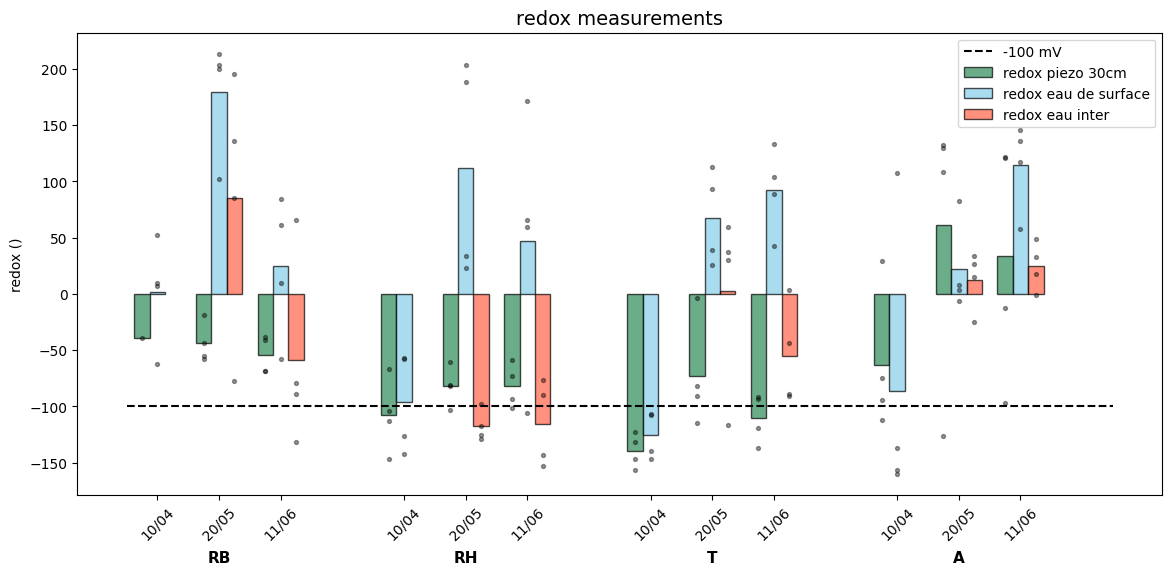

In [15]:
#Plot parameters
bar_width = 1/4
spacing = 1

x_ticks = []
x_labels = []

fig, ax = plt.subplots(figsize=(14, 6))

for i, station in enumerate(stations_babin):
    station_df = df_month_babin[df_month_babin["Station"]==station]
    group_center = i * (len(dates_babin) + spacing) + (len(dates_babin) - 1) / 2
    ax.text(group_center, -0.12, station, ha='center', va='top', fontsize=11, fontweight='bold', transform=ax.get_xaxis_transform())

    for j, date in enumerate(dates_babin):
        data1 = station_df[station_df["Date"] == date]["redox piezo 30cm"]
        data2 = station_df[station_df["Date"] == date]["redox eau de surface"]
        data3 = station_df[station_df["Date"] == date]["redox eau inter"]
        if len(data) == 0:
            continue
        x = i * (len(dates_babin) + spacing) + j

        ax.bar(x-1/4, data1.mean(), width=bar_width, color='seagreen', alpha=0.7, edgecolor='black', label='redox piezo 30cm' if i == 0 and j==0 else "")
        ax.bar(x, data2.mean(), width=bar_width, color='skyblue', alpha=0.7, edgecolor='black',label='redox eau de surface' if i == 0 and j==0 else "")
        ax.bar(x+1/4, data3.mean(), width=bar_width, color='tomato', alpha=0.7, edgecolor='black',label='redox eau inter' if i == 0 and j==0 else "")
        ax.scatter([x-1/4]*len(data1), data1, color='black', alpha=0.4, s=8)
        ax.scatter([x]*len(data2), data2, color='black', alpha=0.4, s=8)
        ax.scatter([x+1/4]*len(data3), data3, color='black', alpha=0.4, s=8)

    
        if i == 0:
            x_labels.append(date.strftime('%d/%m'))
        x_ticks.append(x)  

    # Mean line position
    start_x = i * (len(dates_babin) + spacing) - 0.5
    end_x = start_x + len(dates_babin)

    # ax.hlines(
    #     y=station_df["Salinité à -30cm piézo (g/L)"].mean(),
    #     xmin=start_x,
    #     xmax=end_x ,  
    #     colors='red',
    #     linestyles='--',
    #     linewidth=1.5,
    #     label=f'Moyenne {station}' if i == 0 else ""
    # )

# Dates
ax.set_xticks(x_ticks)
ax.set_xticklabels(
    [d.strftime('%d/%m') for d in dates_babin] * len(stations_babin),  
    rotation=45,
    ha='center'
)
ax.hlines(
    y=-100,
    xmin=-0.5,
    xmax=len(dates_babin) * len(stations_babin) + (len(stations_babin) - 1) * spacing + 0.5,  
    colors='black',
    linestyles='--',
    linewidth=1.5,
    label='-100 mV' 
)
ax.grid(False)
ax.set_ylabel("redox ()")
ax.set_title("redox measurements", fontsize=14)
ax.legend(loc='upper right')
plt.savefig('Plot/redox_Babin.pdf', dpi=300, bbox_inches='tight')

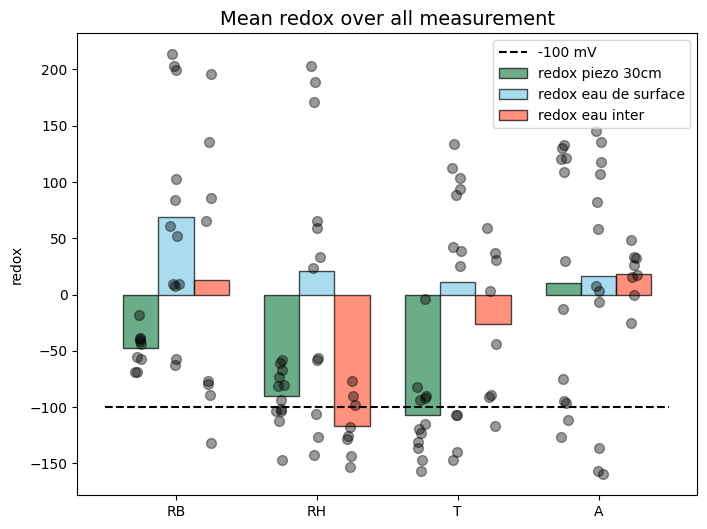

In [16]:

# # Préparer data avec la bonne colonne Station
# data = df_month_babin[["Salinité à -30cm piézo (g/L)", "Station"]].dropna()

# # ANOVA + Tukey
# model = ols('Q("Salinité à -30cm piézo (g/L)") ~ C(Station)', data=data).fit()
# anova_table = sm.stats.anova_lm(model, typ=2)
# tukey = pairwise_tukeyhsd(enredoxg=data["Salinité à -30cm piézo (g/L)"],
#                           groups=data["Station"],
#                           alpha=0.05)

# # --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

bar_width = 1/4
x_pos = range(len(stations_babin))

for i, station in enumerate(stations_babin):
    station_mask = df_month_babin["Parcelle"].str.startswith(station)
    station_df = df_month_babin[station_mask]
    mean_redox_piezo = station_df["redox piezo 30cm"].mean()
    mean_redox_surface = station_df["redox eau de surface"].mean()
    mean_redox_inter = station_df["redox eau inter"].mean()
    ax.bar(x_pos[i]-1/4, mean_redox_piezo, width=bar_width, color='seagreen', alpha=0.7, edgecolor='black',label='redox piezo 30cm' if i == 0 else "")
    ax.bar(x_pos[i], mean_redox_surface, width=bar_width, color='skyblue', alpha=0.7, edgecolor='black', label='redox eau de surface' if i == 0 else "")
    ax.bar(x_pos[i]+1/4, mean_redox_inter, width=bar_width, color='tomato', alpha=0.7, edgecolor='black', label='redox eau inter' if i == 0 else "")
    # print(mean_depth)
    jitter = np.random.normal(loc=0, scale=0.02, size=len(station_df))
    ax.scatter(x_pos[i]-1/4 + jitter, station_df["redox piezo 30cm"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i] + jitter, station_df["redox eau de surface"], color='black', alpha=0.4, s=50)
    ax.scatter(x_pos[i]+1/4 + jitter, station_df["redox eau inter"], color='black', alpha=0.4, s=50)
ax.hlines(
    y=-100,
    xmin=-0.5,
    xmax= 3.5,
    colors='black',
    linestyles='--',
    linewidth=1.5,
    label='-100 mV'
)
ax.set_xticks(x_pos)
ax.set_xticklabels(stations_babin)
ax.set_ylabel("redox")
ax.set_title("Mean redox over all measurement", fontsize=14)
ax.grid(False)
ax.legend(loc='upper right')
# --- Statannotations ---
# # Comparaisons voulues
# comparisons = [("RB", "RH"), ("RH", "T"), ("T", "A")]

# annotator = Annotator(ax, comparisons, data=data, x="Station", y="Salinité à -30cm piézo (g/L)")
# annotator.configure(test=None, text_format='star')  # Pas de test automatique

# # On injecte les p-values du test Tukey dans l'annotator
# pvalues = []
# for pair in comparisons:
#     # Tukey retourne les p-values par paire dans tukey.summary()
#     # tukey._results_table.data est une liste de listes : [['group1', 'group2', 'meandiff', 'p-adj', 'lower', 'upper', 'reject'], ...]
#     for row in tukey._results_table.data[1:]:
#         if (row[0], row[1]) == pair or (row[1], row[0]) == pair:
#             pvalues.append(float(row[3]))
#             break

# annotator.set_pvalues(pvalues)
# annotator.annotate()
# plt.savefig("Plot/salinite_anova_tukey.pdf", dpi=300, bbox_inches='tight')
# plt.tight_layout()
# plt.show()
plt.savefig('Plot/Mean_redox_Babin.pdf', dpi=300, bbox_inches='tight')

$\textbf{PCA ON ALL VARIABLE}$

In [18]:
numeric_columns = df_babin.select_dtypes(include=[np.number]).columns
df_moyennes_babin = df_babin.groupby('Parcelle')[numeric_columns].mean().reset_index()
numeric_columns_month = df_month_babin.select_dtypes(include=[np.number]).columns
df_moyennes_month_babin = df_month_babin.groupby('Parcelle')[numeric_columns_month].mean().reset_index()
df_babin_tot_mean = pd.merge(df_moyennes_babin, df_moyennes_month_babin, on='Parcelle')


In [23]:
df_babin_tot_mean

,Parcelle,Profondeur de nappe (cm),Salinité à -30cm piézo (g/L),Salinité en surface piézo (g/L),Salinité en surface dehors (g/L),Salinité eau inter -30cm (g/L),pH piezo 30cm,DO piezo 30cm,redox piezo 30cm,pH eau de surface,DO eau de surface,redox eau de surface,pH eau inter,DO eau inter,redox eau inter
0,A1,-16.181818,55.090909,51.142857,31.857143,50.0,7.206667,2.836667,94.433333,7.660000,2.290000,82.200000,6.785,0.190,21.90
1,A2,-6.363636,49.727273,49.428571,32.000000,31.5,7.406667,0.506667,-105.933333,7.556667,2.596667,-3.900000,6.960,0.175,3.70
2,A3,-6.409091,50.727273,48.285714,30.428571,43.0,7.250000,1.273333,51.566667,7.540000,1.453333,-5.966667,6.885,0.200,41.05
3,A4,-12.000000,48.363636,46.714286,27.857143,41.0,7.220000,0.870000,1.933333,7.523333,1.473333,-6.400000,6.850,0.195,7.30
4,RB1,1.909091,38.272727,32.285714,33.285714,37.5,7.276667,3.603333,-46.750000,7.280000,3.696667,116.566667,6.915,0.200,-83.15
5,RB2,0.727273,37.590909,32.142857,33.714286,37.0,7.280000,4.710000,-29.850000,7.116667,2.660000,51.900000,6.925,0.285,2.00
6,RB3,-3.636364,38.454545,31.857143,32.428571,36.5,6.950000,2.873333,-50.533333,7.263333,2.790000,16.533333,7.035,0.810,3.05
7,RB4,0.636364,38.545455,33.000000,33.000000,36.0,7.110000,2.806667,-63.050000,7.220000,3.620000,89.266667,6.995,0.205,130.40
8,RH1,-1.545455,42.545455,28.285714,23.285714,42.0,6.713333,2.476667,-74.300000,7.136667,2.363333,65.166667,6.660,0.235,-103.85
9,RH2,1.454545,42.272727,37.571429,24.714286,43.0,7.090000,1.580000,-117.133333,7.073333,1.806667,13.533333,6.845,0.210,-135.95


Correspondance vecteurs affichés :
1 = pH eau inter
2 = Profondeur de nappe (cm)
3 = redox eau inter
4 = Salinité à -30cm piézo (g/L)
5 = Salinité en surface piézo (g/L)
6 = pH eau de surface
7 = Salinité en surface dehors (g/L)


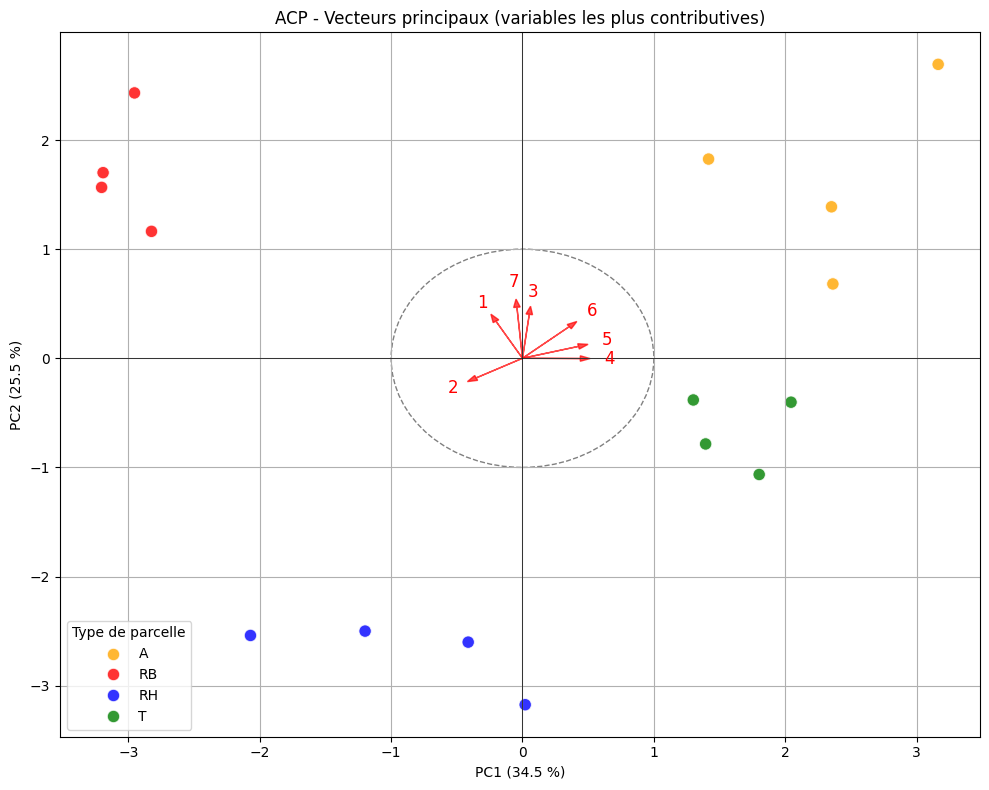

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import re

# 1. Données
X = df_babin_tot_mean.drop('Parcelle', axis=1)
y = df_babin_tot_mean['Parcelle']

variables = X.columns.tolist()

# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. DataFrame des individus
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Parcelle'] = y.values

# 5. Coordonnées des vecteurs
components = pca.components_.T  # shape (variables, 2)

# 6. Importance des variables = norme au carré des coordonnées
importance = np.sum(components**2, axis=1)

# 7. Sélection des variables les plus importantes (moitié)
n_keep = len(variables) // 2
top_idx = np.argsort(importance)[-n_keep:]  # indices des plus fortes contributions

# 8. Couleurs des parcelles
colors = {
    'RB': 'red',
    'RH': 'blue',
    'T': 'green',
    'A': 'orange'
}

# 9. Préfixe parcelle pour légende
df_pca['Prefix'] = df_pca['Parcelle'].apply(lambda p: re.match(r'([A-Z]+)', p).group(1))

# 10. Affichage
plt.figure(figsize=(10, 8))

# a. Scatterplot des individus
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Prefix',
                palette=colors, s=80, alpha=0.8)

# b. Vecteurs filtrés avec numéros
for j, i in enumerate(top_idx):
    plt.arrow(0, 0, components[i, 0], components[i, 1],
              color='red', alpha=0.7, head_width=0.05)
    plt.text(components[i, 0]*1.5, components[i, 1]*1.5,
             str(j+1), color='red', fontsize=12, ha='center', va='center')

# c. Cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)

# d. Axes et titres
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)")
plt.title("ACP - Vecteurs principaux (variables les plus contributives)")

plt.grid(True)
plt.legend(title="Type de parcelle")
plt.tight_layout()

# e. Affichage des correspondances variables ↔ numéros
top_mapping = {str(j+1): variables[i] for j, i in enumerate(top_idx)}
print("Correspondance vecteurs affichés :")
for num, var in top_mapping.items():
    print(f"{num} = {var}")


# Sauvegarde
#plt.savefig('Plot/PCA_Babin_top.pdf', dpi=300, bbox_inches='tight')
plt.show()


Contenu des composantes principales :
     Profondeur de nappe (cm)  Salinité à -30cm piézo (g/L)  \
PC1                 -0.352482                      0.440156   
PC2                 -0.179794                     -0.002190   

     Salinité en surface piézo (g/L)  Salinité en surface dehors (g/L)  \
PC1                         0.426446                         -0.042372   
PC2                         0.109028                          0.467402   

     Salinité eau inter -30cm (g/L)  pH piezo 30cm  DO piezo 30cm  \
PC1                        0.269122       0.146002      -0.334586   
PC2                       -0.211964       0.304329       0.162245   

     redox piezo 30cm  pH eau de surface  DO eau de surface  \
PC1          0.101065            0.35574          -0.181927   
PC2          0.300181            0.28976           0.264532   

     redox eau de surface  pH eau inter  DO eau inter  redox eau inter  
PC1             -0.236717     -0.202014     -0.152647         0.051652  
PC2  

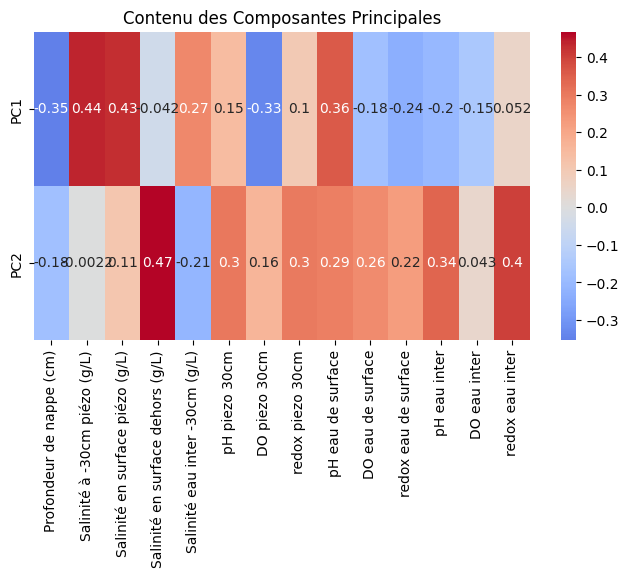

In [21]:
import pandas as pd

# Créer un DataFrame avec les composantes principales et les noms des caractéristiques
components_df = pd.DataFrame(pca.components_, columns=X.columns, index=['PC1', 'PC2'])

print("Contenu des composantes principales :")
print(components_df)
import seaborn as sns

plt.figure(figsize=(8, 4))
sns.heatmap(components_df, annot=True, cmap='coolwarm', center=0)
plt.title('Contenu des Composantes Principales')
plt.savefig('Plot/PCA_Babin_correlations.pdf', dpi=300, bbox_inches='tight')

plt.show()


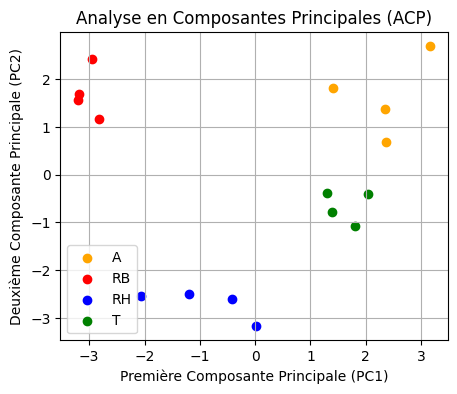

Variance expliquée par chaque composante principale: [3.44989509e-01 2.55286552e-01 1.08096343e-01 9.25616228e-02
 9.13973062e-02 3.93995003e-02 2.90969051e-02 1.57862207e-02
 1.22582457e-02 5.43010630e-03 3.56996294e-03 1.53029630e-03
 4.45009045e-04 1.52420507e-04]


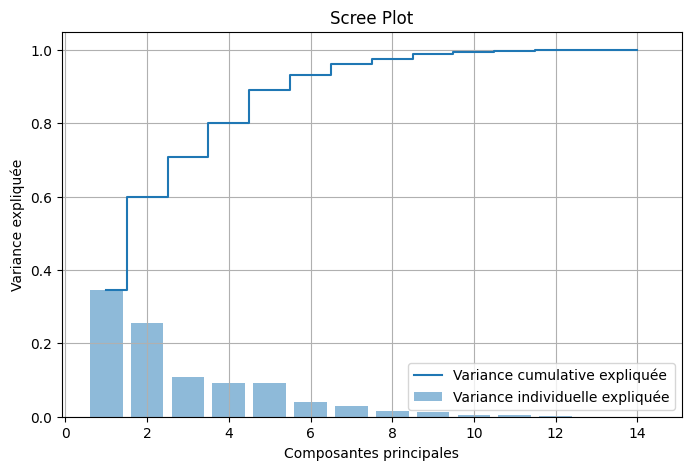

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import re

# Séparer les caractéristiques et les étiquettes
X = df_babin_tot_mean.drop('Parcelle', axis=1)
y = df_babin_tot_mean['Parcelle']

# Normaliser les données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Réaliser l'ACP
pca = PCA()
principal_components = pca.fit_transform(X_scaled)

# Créer un DataFrame avec les composantes principales
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(X_scaled.shape[1])])
pca_df['Parcelle'] = y

# Visualiser les résultats de l'ACP
plt.figure(figsize=(5, 4))
colors = {
    'RB': 'red',
    'RH': 'blue',
    'T': 'green',
    'A': 'orange'
}
i = 0
for parcelle in pca_df['Parcelle'].unique():
    prefix = re.match(r'([A-Z]+)', parcelle).group(1)
    color = colors.get(prefix, 'black')
    plt.scatter(pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC1'],
                pca_df.loc[pca_df['Parcelle'] == parcelle, 'PC2'],
                label=prefix if i % 4 == 0 else "", color=color)
    i += 1

plt.xlabel('Première Composante Principale (PC1)')
plt.ylabel('Deuxième Composante Principale (PC2)')
plt.title('Analyse en Composantes Principales (ACP)')
plt.legend()
plt.grid()
plt.show()

# Afficher la variance expliquée par chaque composante principale
print("Variance expliquée par chaque composante principale:", pca.explained_variance_ratio_)

# Scree plot
plt.figure(figsize=(8, 5))
plt.bar(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, alpha=0.5, align='center', label='Variance individuelle expliquée')
plt.step(range(1, len(pca.explained_variance_ratio_) + 1), np.cumsum(pca.explained_variance_ratio_), where='mid', label='Variance cumulative expliquée')
plt.ylabel('Variance expliquée')
plt.xlabel('Composantes principales')
plt.title('Scree Plot')
plt.savefig('Plot/PCA_Babin_ScreePlot.pdf', dpi=300, bbox_inches='tight')

plt.legend()
plt.grid()
plt.show()


$\textbf{CORRELATIONS ENTRE TOUS LES PARAMETRES}$

Matrice de correlations des paramètres utilisés dans l'ACP

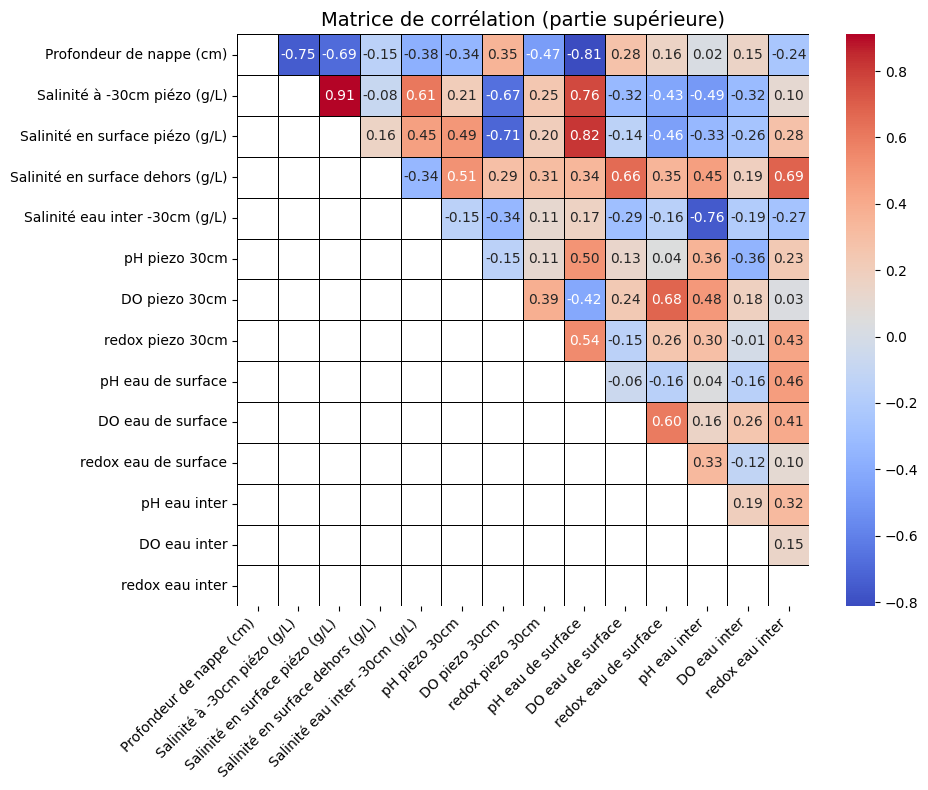

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Supprimer la première colonne (ex : 'Parcelle')
df_corr = df_babin_tot_mean.iloc[:, 1:]  

# 2. Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

# 3. Masque pour n’afficher que la partie supérieure
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# 4. Heatmap triangulaire avec lignes de séparation
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=.5,       # largeur des lignes de séparation
    linecolor='k',  # couleur des lignes
    annot_kws={"size":10}  # taille des annotations
)

plt.title("Matrice de corrélation (partie supérieure)", fontsize=14)
plt.xticks(rotation=45, ha='right')  # rotation des labels colonnes pour lisibilité
plt.yticks(rotation=0)               # labels lignes horizontaux
plt.tight_layout()
plt.savefig('Plot/Correlation_Babin.pdf', dpi=300, bbox_inches='tight')
plt.show()


Matrice de correlations des mesures hebdo sur toutes les valeurs mesurées depuis le début de la Guadeloupe

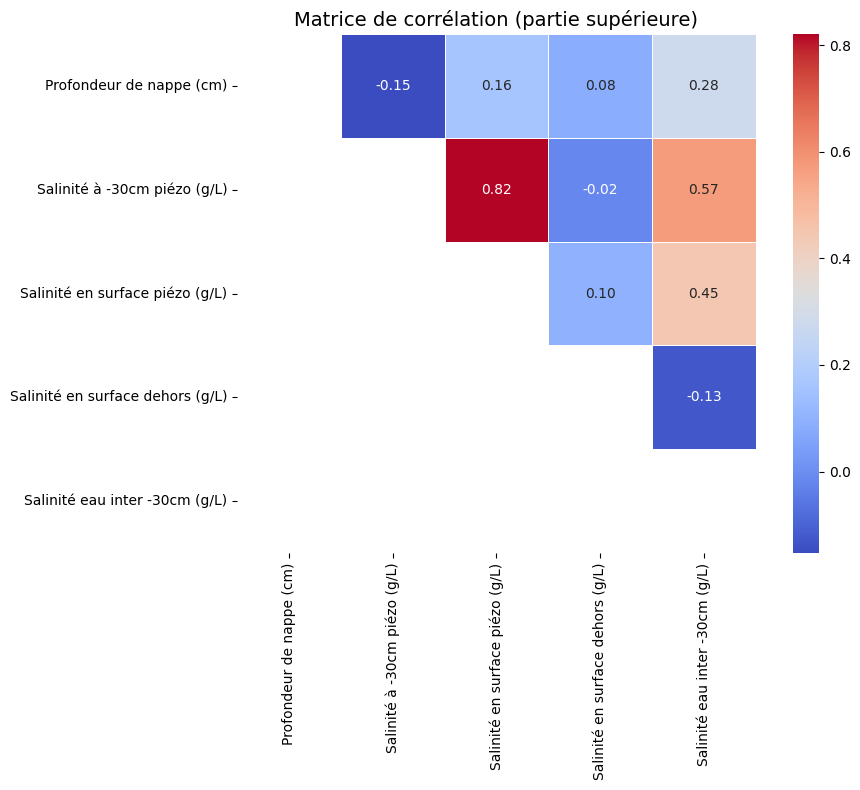

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Supprimer la première colonne (ex : 'Parcelle')
df_corr = df_babin.iloc[:, 3:]  

# 2. Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

# 3. Masque pour n’afficher que la partie supérieure
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# 4. Heatmap triangulaire
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", cmap="coolwarm",
            cbar=True, square=True, linewidths=0.5)

plt.title("Matrice de corrélation (partie supérieure)", fontsize=14)
plt.tight_layout()
plt.show()


Calcul du coefficient de correlation entre la salinité à 30cm et la profondeur en fonction des dates

In [25]:
df_dry = df_babin.head(16)[['Profondeur de nappe (cm)','Salinité à -30cm piézo (g/L)']]
df_wet = df_babin.iloc[16:][['Profondeur de nappe (cm)','Salinité à -30cm piézo (g/L)']]

pearson_coef_dry = df_dry['Profondeur de nappe (cm)'].corr(df_dry['Salinité à -30cm piézo (g/L)'], method='pearson')
pearson_coef_wet = df_wet['Profondeur de nappe (cm)'].corr(df_wet['Salinité à -30cm piézo (g/L)'], method='pearson')

print(f"Pearson coefficient dry season: {pearson_coef_dry:.2f}")
print(f"Pearson coefficient wet season: {pearson_coef_wet:.2f}")

Pearson coefficient dry season: -0.68
Pearson coefficient wet season: -0.06


$\textbf{IMPORTANT} \newline$
Si on compare les valeurs de correlations pour les mesures hebdo, notamment les correlations salinité à 30cm de profondeur vs profondeur de nappe il y a un biais statistique. On remarque que pour les grandeurs moyennées par parcelles (dans la grande matrice de corraltions des grandeurs utilisées pour l'ACP), le coefficient qui relie ces grandeures est de -.75 et qu'il est de -.15 lorsque l'on ne prend pas les moyennes mais bien toutes les valeurs individuellement. Si on pousse encore plus l'analyse on se rend compte que le coefficient de correlations (pour les valeurs individuelles) monte à -.68 en ne prenant les valeurs que sur la saison sèche et on tombe à -.06 sur la saison sèche $\newline$ On peut le visualiser avec les plots ci dessous

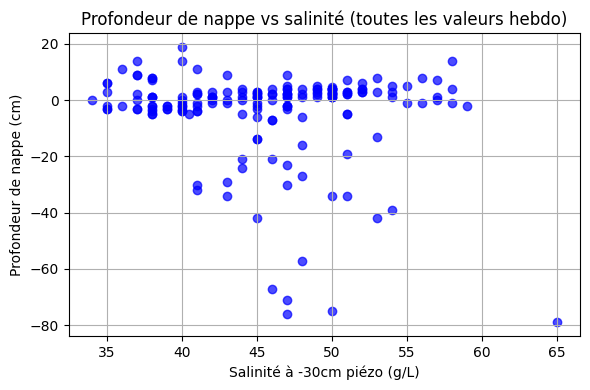

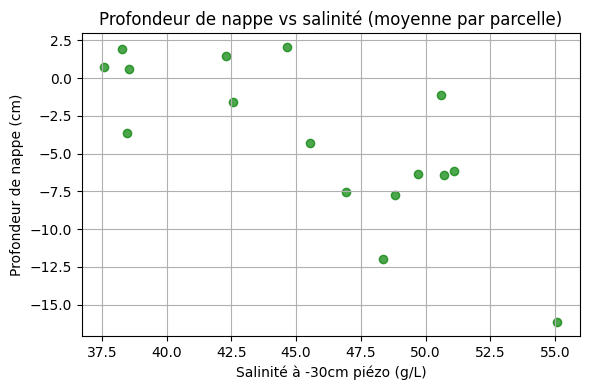

In [26]:
import matplotlib.pyplot as plt

# Graphique 1 : df_babin
df_plot1 = df_babin.iloc[:, 3:]
plt.figure(figsize=(6, 4))
plt.scatter(df_babin['Salinité à -30cm piézo (g/L)'], df_babin['Profondeur de nappe (cm)'], color='blue', alpha=0.7)
plt.xlabel('Salinité à -30cm piézo (g/L)')
plt.ylabel('Profondeur de nappe (cm)')
plt.title("Profondeur de nappe vs salinité (toutes les valeurs hebdo)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Graphique 2 : df_moyennes_babin
plt.figure(figsize=(6, 4))
plt.scatter(df_moyennes_babin['Salinité à -30cm piézo (g/L)'], df_moyennes_babin['Profondeur de nappe (cm)'], color='green', alpha=0.7)
plt.xlabel('Salinité à -30cm piézo (g/L)')
plt.ylabel('Profondeur de nappe (cm)')
plt.title("Profondeur de nappe vs salinité (moyenne par parcelle)")
plt.grid(True)
plt.tight_layout()
plt.show()


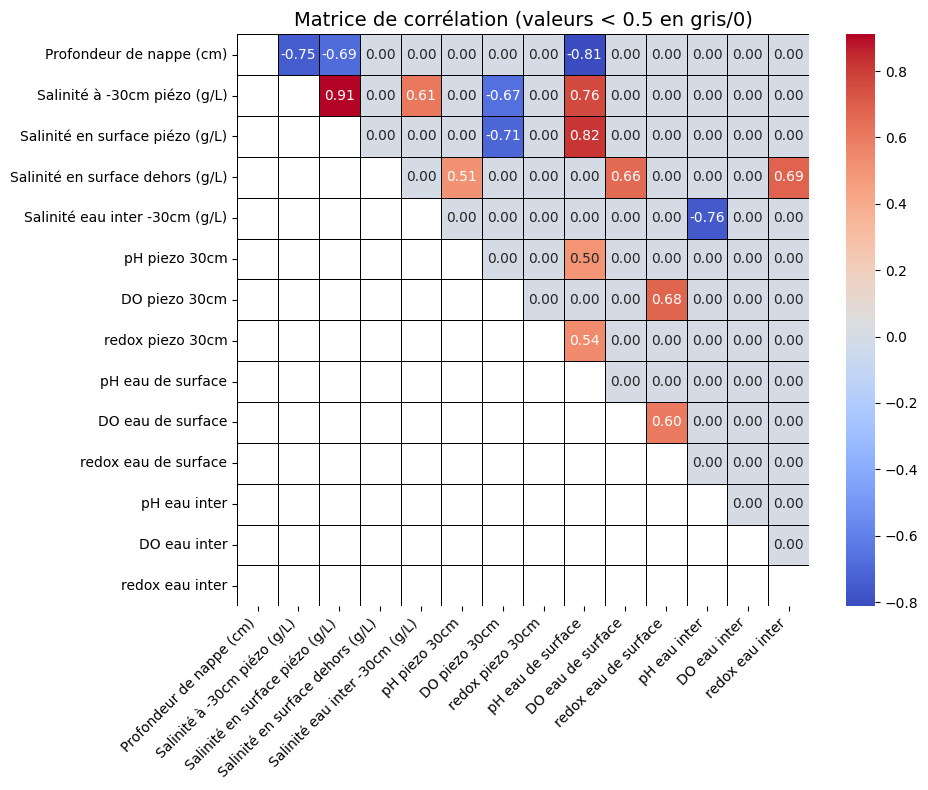

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Supprimer la première colonne (ex : 'Parcelle')
df_corr = df_babin_tot_mean.iloc[:, 1:]  

# 2. Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

# 3. Mettre à 0 les valeurs absolues < 0.5
corr_matrix_masked = corr_matrix.copy()
corr_matrix_masked[np.abs(corr_matrix_masked) < 0.5] = 0

# 4. Masque pour n’afficher que la partie supérieure
mask = np.tril(np.ones_like(corr_matrix_masked, dtype=bool))

# 5. Heatmap triangulaire avec lignes de séparation
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix_masked,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=.5,
    linecolor='k',
    annot_kws={"size":10}
)

plt.title("Matrice de corrélation (valeurs < 0.5 en gris/0)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('Plot/Correlation_Babin_masked.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [39]:
key_cols = ['Station', 'Parcelle', 'Date']

# Merge outer
df_merged = pd.merge(
    df_month_babin, 
    df_babin, 
    on=key_cols,  # colonnes communes pour lier les deux dfs
    how='outer'   # garde toutes les lignes et met NaN quand il n'y a pas de correspondance
)

# Affichage rapide pour vérifier



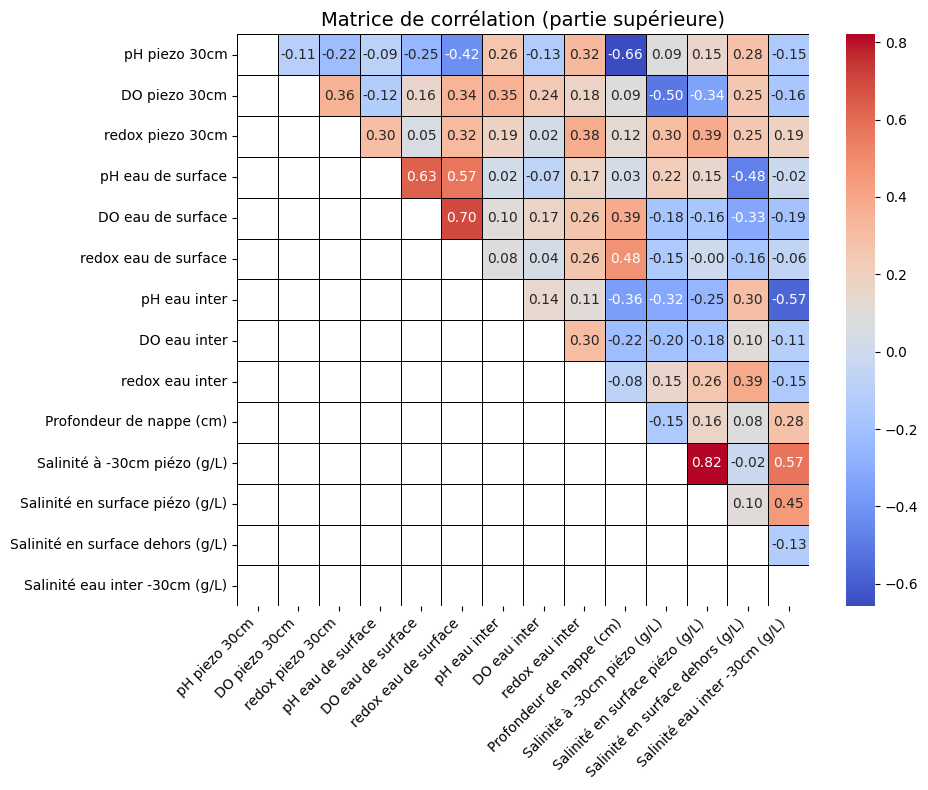

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Supprimer la première colonne (ex : 'Parcelle')
df_corr = df_merged.iloc[:, 3:]  

# 2. Calcul de la matrice de corrélation
corr_matrix = df_corr.corr()

# 3. Masque pour n’afficher que la partie supérieure
mask = np.tril(np.ones_like(corr_matrix, dtype=bool))

# 4. Heatmap triangulaire avec lignes de séparation
plt.figure(figsize=(10, 8))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=.5,       # largeur des lignes de séparation
    linecolor='k',  # couleur des lignes
    annot_kws={"size":10}  # taille des annotations
)

plt.title("Matrice de corrélation (partie supérieure)", fontsize=14)
plt.xticks(rotation=45, ha='right')  # rotation des labels colonnes pour lisibilité
plt.yticks(rotation=0)               # labels lignes horizontaux
plt.tight_layout()
plt.savefig('Plot/Correlation_Babin.pdf', dpi=300, bbox_inches='tight')
plt.show()


In [45]:
df_merged.drop(df_merged.columns[[0, 2]], axis=1)

,Parcelle,pH piezo 30cm,DO piezo 30cm,redox piezo 30cm,pH eau de surface,DO eau de surface,redox eau de surface,pH eau inter,DO eau inter,redox eau inter,Profondeur de nappe (cm),Salinité à -30cm piézo (g/L),Salinité en surface piézo (g/L),Salinité en surface dehors (g/L),Salinité eau inter -30cm (g/L)
0,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-79.0,65.0,NaN,NaN,NaN
1,A1,7.75,2.26,29.4,7.71,0.86,107.4,NaN,NaN,NaN,-39.0,54.0,NaN,NaN,NaN
2,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-42.0,53.0,NaN,NaN,NaN
3,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,57.0,NaN,NaN,NaN
4,A1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,56.0,50.0,36.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,T4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,52.0,52.0,19.0,NaN
172,T4,6.80,0.21,-3.6,7.44,3.64,25.2,6.50,0.66,37.2,4.0,50.0,49.0,30.0,47.0
173,T4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,52.0,52.0,25.0,NaN
174,T4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,46.0,46.0,41.0,NaN


$\textbf{IMPROTANT}$ Il reste à supprimer les colonnes 1 et 3 de df_merged puis de refaire l'ACP

Correspondance vecteurs affichés :
1 = DO piezo 30cm
2 = Salinité en surface piézo (g/L)
3 = Profondeur de nappe (cm)
4 = redox eau de surface
5 = Salinité à -30cm piézo (g/L)
6 = DO eau de surface
7 = pH eau de surface


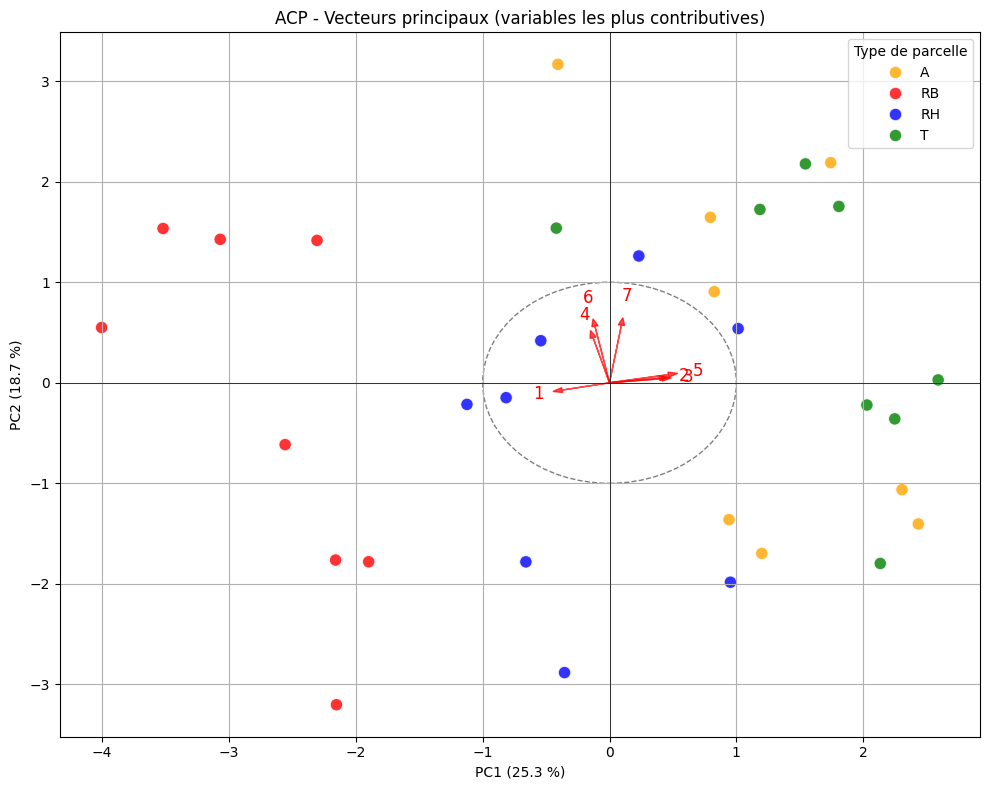

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns

# Supposons que ton tableau s'appelle df_merged
# La première colonne est la variable expliquée, toutes les autres sont explicatives
df_pca_input = df_merged.drop(df_merged.columns[[0, 2]], axis=1)
df_pca_input = df_pca_input.dropna()  # supprime les lignes avec NaN

# 1. Données
X = df_pca_input.drop('Parcelle', axis=1)
y = df_pca_input['Parcelle']

variables = X.columns.tolist()

# 2. Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. ACP
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# 4. DataFrame des individus
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['Parcelle'] = y.values

# 5. Coordonnées des vecteurs
components = pca.components_.T  # shape (variables, 2)

# 6. Importance des variables = norme au carré des coordonnées
importance = np.sum(components**2, axis=1)

# 7. Sélection des variables les plus importantes (moitié)
n_keep = len(variables) // 2
top_idx = np.argsort(importance)[-n_keep:]  # indices des plus fortes contributions

# 8. Couleurs des parcelles
colors = {
    'RB': 'red',
    'RH': 'blue',
    'T': 'green',
    'A': 'orange'
}

# 9. Préfixe parcelle pour légende
df_pca['Prefix'] = df_pca['Parcelle'].apply(lambda p: re.match(r'([A-Z]+)', p).group(1))

# 10. Affichage
plt.figure(figsize=(10, 8))

# a. Scatterplot des individus
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='Prefix',
                palette=colors, s=80, alpha=0.8)

# b. Vecteurs filtrés avec numéros
for j, i in enumerate(top_idx):
    plt.arrow(0, 0, components[i, 0], components[i, 1],
              color='red', alpha=0.7, head_width=0.05)
    plt.text(components[i, 0]*1.5, components[i, 1]*1.5,
             str(j+1), color='red', fontsize=12, ha='center', va='center')

# c. Cercle unité
circle = plt.Circle((0, 0), 1, color='gray', fill=False, linestyle='--')
plt.gca().add_patch(circle)

# d. Axes et titres
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f} %)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f} %)")
plt.title("ACP - Vecteurs principaux (variables les plus contributives)")

plt.grid(True)
plt.legend(title="Type de parcelle")
plt.tight_layout()

# e. Affichage des correspondances variables ↔ numéros
top_mapping = {str(j+1): variables[i] for j, i in enumerate(top_idx)}
print("Correspondance vecteurs affichés :")
for num, var in top_mapping.items():
    print(f"{num} = {var}")


# Sauvegarde
#plt.savefig('Plot/PCA_Babin_top.pdf', dpi=300, bbox_inches='tight')
plt.show()
